In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

games = pd.read_csv("Data/games.csv")
player_play = pd.read_csv("Data/player_play.csv")
players = pd.read_csv("Data/players.csv")
plays = pd.read_csv("Data/plays.csv")
week_1 = pd.read_csv("Data/tracking_week_1.csv")
week_2 = pd.read_csv("Data/tracking_week_2.csv")
week_3 = pd.read_csv("Data/tracking_week_3.csv")
week_4 = pd.read_csv("Data/tracking_week_4.csv")
week_5 = pd.read_csv("Data/tracking_week_5.csv")
week_6 = pd.read_csv("Data/tracking_week_6.csv")
week_7 = pd.read_csv("Data/tracking_week_7.csv")
week_8 = pd.read_csv("Data/tracking_week_8.csv")
week_9 = pd.read_csv("Data/tracking_week_9.csv")

tracking = pd.concat([
    week_1, week_2, week_3, week_4, week_5, 
    week_6, week_7, week_8, week_9
], ignore_index=True)

In [2]:
plays_player_play = pd.merge(player_play, plays, on=["gameId", "playId"], how="inner")
full_player_data = pd.merge(plays_player_play, players, on="nflId", how="left")

passing_plays = full_player_data[full_player_data['isDropback'] == True].copy()

off_line_positions = {'CB', 'S', 'FS', 'SS', 'OLB', 'MLB', 'ILB'}
defenders_off_line = passing_plays[passing_plays['position'].isin(off_line_positions)].copy()

offensive_skill_positions = {'WR', 'TE', 'RB', 'HB', 'FB'}
route_runners = passing_plays[
    (passing_plays['position'].isin(offensive_skill_positions)) & 
    (passing_plays['wasRunningRoute'] == 1)
].copy()

def pad_time_fraction(time_str):
    if pd.isnull(time_str):
        return time_str
    if '.' in time_str:
        base, frac = time_str.split('.')
        frac_padded = frac.ljust(6, '0')[:6]
        return f"{base}.{frac_padded}"
    return time_str

tracking['time_corrected'] = tracking['time'].apply(pad_time_fraction)
tracking['time_dt'] = pd.to_datetime(tracking['time_corrected'], errors='coerce')

unique_events = tracking['event'].unique()
unique_frame_types = tracking['frameType'].unique()

key_events = ['line_set', 'ball_snap']

def get_play_time_window_events(track_data):
    start_event = 'line_set'
    snap_event = 'ball_snap'
    
    start_row = track_data[track_data['event'] == start_event]
    snap_row = track_data[track_data['event'] == snap_event]
    
    if len(start_row) == 0 or len(snap_row) == 0:
        return None, None

    line_set_time = start_row['time_dt'].iloc[0]
    ball_snap_time = snap_row['time_dt'].iloc[0]

    if line_set_time >= ball_snap_time:
        return None, None

    cutoff_time = ball_snap_time - pd.Timedelta(seconds=2)
    return line_set_time, cutoff_time

use_event_based_filtering = ('line_set' in unique_events) and ('ball_snap' in unique_events)

filtered_tracking = []
grouped_tracking = tracking.groupby(['gameId', 'playId'])

for (gId, pId), group in grouped_tracking:
    if use_event_based_filtering:
        start_time, cutoff_time = get_play_time_window_events(group)
    else:
        start_time = group['time_dt'].min()
        cutoff_time = start_time + pd.Timedelta(seconds=2)
    
    if (start_time is not None) and (cutoff_time is not None) and (start_time < cutoff_time):
        subset = group[(group['time_dt'] >= start_time) & (group['time_dt'] <= cutoff_time)]
        if not subset.empty:
            filtered_tracking.append(subset)

if filtered_tracking:
    filtered_tracking = pd.concat(filtered_tracking, ignore_index=True)
else:
    filtered_tracking = pd.DataFrame(columns=tracking.columns)

defender_tracking = pd.merge(
    filtered_tracking, 
    defenders_off_line[['gameId','playId','nflId','pff_defensiveCoverageAssignment']],
    on=["gameId","playId","nflId"], 
    how="inner"
)

offense_tracking = pd.merge(
    filtered_tracking, 
    route_runners[['gameId','playId','nflId']], 
    on=["gameId","playId","nflId"], 
    how="inner"
)
offense_tracking.rename(columns={
    'nflId':'offNflId',
    'x':'off_x',
    'y':'off_y',
    's':'off_s',
    'a':'off_a'
}, inplace=True)

merged_tracking = pd.merge(
    defender_tracking,
    offense_tracking[['gameId','playId','frameId','offNflId','off_x','off_y']],
    on=['gameId','playId','frameId'],
    how='inner'
)

merged_tracking['distance_to_offense'] = np.sqrt(
    (merged_tracking['x'] - merged_tracking['off_x'])**2 +
    (merged_tracking['y'] - merged_tracking['off_y'])**2
)

distance_agg = merged_tracking.groupby(['gameId','playId','nflId']).agg({
    'x': ['mean','std'],
    'y': ['mean','std'],
    's': ['mean','std'],
    'a': ['mean','std'],
    'distance_to_offense': ['mean','std','min','max']
}).reset_index()

distance_agg.columns = [
    'gameId','playId','nflId',
    'x_mean','x_std','y_mean','y_std',
    's_mean','s_std','a_mean','a_std',
    'dist_mean','dist_std','dist_min','dist_max'
]

defender_tracking_sorted = defender_tracking.sort_values(['gameId','playId','nflId','frameId'])

defender_start_end = (
    defender_tracking_sorted
    .groupby(['gameId','playId','nflId'])
    .agg(
        start_x=('x','first'),
        start_y=('y','first'),
        end_x=('x','last'),
        end_y=('y','last')
    )
    .reset_index()
)

merged_tracking_sorted = merged_tracking.sort_values(['gameId','playId','nflId','frameId'])

defender_start_end_dist = []
for (gId, pId, dId), group_df in merged_tracking_sorted.groupby(['gameId','playId','nflId']):
    first_row = group_df.iloc[0]
    last_row = group_df.iloc[-1]
    
    first_frame_id = first_row['frameId']
    last_frame_id = last_row['frameId']

    first_frame_df = group_df[group_df['frameId'] == first_frame_id]
    last_frame_df  = group_df[group_df['frameId'] == last_frame_id]
    
    start_dist = first_frame_df['distance_to_offense'].min()
    end_dist   = last_frame_df['distance_to_offense'].min()
    
    defender_start_end_dist.append({
        'gameId': gId,
        'playId': pId,
        'nflId': dId,
        'start_distance': start_dist,
        'end_distance': end_dist
    })

defender_start_end_dist = pd.DataFrame(defender_start_end_dist)

distance_agg = pd.merge(distance_agg, defender_start_end, on=['gameId','playId','nflId'], how='left')
distance_agg = pd.merge(distance_agg, defender_start_end_dist, on=['gameId','playId','nflId'], how='left')

if 'pff_defensiveCoverageAssignment' in defender_tracking.columns:
    coverage_label_column = 'pff_defensiveCoverageAssignment'
else:
    defender_tracking = defender_tracking.rename(columns={'pff_passCoverage': 'pff_defensiveCoverageAssignment'})
    coverage_label_column = 'pff_defensiveCoverageAssignment'

coverage_info = defender_tracking[['gameId','playId','nflId', coverage_label_column]].drop_duplicates()
coverage_info = coverage_info.dropna(subset=[coverage_label_column])

agg_merged = pd.merge(distance_agg, coverage_info, on=["gameId","playId","nflId"], how="inner")

position_info = defenders_off_line[['gameId','playId','nflId','position']].drop_duplicates()
agg_merged = pd.merge(agg_merged, position_info, on=["gameId","playId","nflId"], how="left")

agg_merged = agg_merged.dropna(subset=[coverage_label_column])

le_coverage = LabelEncoder()
agg_merged['coverage_label'] = le_coverage.fit_transform(agg_merged[coverage_label_column].astype(str))

le_position = LabelEncoder()
agg_merged['position_encoded'] = le_position.fit_transform(agg_merged['position'].astype(str))

feature_cols = [
    'x_mean','x_std','y_mean','y_std','s_mean','s_std','a_mean','a_std',
    'dist_mean','dist_std','dist_min','dist_max',
    'position_encoded',

    'start_x','start_y','end_x','end_y',
    'start_distance','end_distance'
]

X = agg_merged[feature_cols].fillna(0)
y = agg_merged['coverage_label']

# Search to find optimal parameters...don't need to run again

In [3]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import accuracy_score, log_loss
# from sklearn.ensemble import RandomForestClassifier
# from scipy.stats import randint, uniform

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# param_distributions = {
#     'n_estimators': randint(100, 1001),
#     'max_depth': [10, 20, None],
#     'min_samples_split': randint(2, 21),
#     'min_samples_leaf': randint(1, 21),
#     'max_features': ['sqrt', 'log2', None]
# }

# model_rf = RandomForestClassifier(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=model_rf,
#     param_distributions=param_distributions,
#     n_iter=30,
#     scoring='accuracy',
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best parameters found by RandomizedSearchCV:")
# print(random_search.best_params_)
# print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# best_model = random_search.best_estimator_

# y_val_pred = best_model.predict(X_val)
# coverage_probs = best_model.predict_proba(X_val)

# val_accuracy = accuracy_score(y_val, y_val_pred)
# val_logloss = log_loss(y_val, coverage_probs)

# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Validation Log Loss: {val_logloss:.4f}")


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_coverage = RandomForestClassifier(
    n_estimators = 871,
    max_depth = 20,
    max_features = 'log2',
    min_samples_leaf = 6,
    min_samples_split = 11
)
model_coverage.fit(X_train, y_train)

coverage_probs = model_coverage.predict_proba(X_val)
y_val_pred = model_coverage.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
logloss = log_loss(y_val, coverage_probs)

print(f"Coverage Model Validation Accuracy: {accuracy:.4f}")
print(f"Coverage Model Validation Log Loss: {logloss:.4f}")
print(f"Coverage Classes: {le_coverage.classes_}")

Coverage Model Validation Accuracy: 0.3527
Coverage Model Validation Log Loss: 1.8276
Coverage Classes: ['2L' '2R' '3L' '3M' '3R' '4IL' '4IR' '4OL' '4OR' 'CFL' 'CFR' 'DF' 'FL'
 'FR' 'HCL' 'HCR' 'HOL' 'MAN' 'PRE']


In [4]:
coverage_probs = model_coverage.predict_proba(X_train)
y_train_pred = model_coverage.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
logloss = log_loss(y_train, coverage_probs)

print(f"Coverage Model Training Accuracy: {accuracy:.4f}")
print(f"Coverage Model Training Log Loss: {logloss:.4f}")
print(f"Coverage Classes: {le_coverage.classes_}")

Coverage Model Training Accuracy: 0.7457
Coverage Model Training Log Loss: 1.1737
Coverage Classes: ['2L' '2R' '3L' '3M' '3R' '4IL' '4IR' '4OL' '4OR' 'CFL' 'CFR' 'DF' 'FL'
 'FR' 'HCL' 'HCR' 'HOL' 'MAN' 'PRE']


In [6]:
x = 2

X_player = X_val.iloc[x]

X_player_2d = pd.DataFrame([X_player], columns = X_val.columns)

proba = model_coverage.predict_proba(X_player_2d)[0]

coverage_classes = le_coverage.classes_

probabilities_df = pd.DataFrame({
    'Coverage_Class': coverage_classes,
    'Probability': proba
}).sort_values('Probability', ascending=False)

print(probabilities_df)

top_class = coverage_classes[np.argmax(proba)]
print(f"Top predicted class for this player: {top_class}")

print(f"Actual class for this player: {le_coverage.inverse_transform([y_train.iloc[x]])[0]}")


   Coverage_Class  Probability
16            HOL     0.216700
17            MAN     0.183951
11             DF     0.166545
6             4IR     0.129489
5             4IL     0.056007
15            HCR     0.050528
3              3M     0.047948
10            CFR     0.045287
14            HCL     0.044044
9             CFL     0.030067
0              2L     0.013228
1              2R     0.006681
18            PRE     0.005080
4              3R     0.002058
12             FL     0.001478
13             FR     0.000794
2              3L     0.000115
8             4OR     0.000000
7             4OL     0.000000
Top predicted class for this player: HOL
Actual class for this player: HOL


In [7]:
def predict_coverage_for_play(gameId, playId, model_coverage, le_coverage, le_position, distance_agg, defenders_off_line):
    this_play_defenders = defenders_off_line[(defenders_off_line['gameId'] == gameId) & 
                                             (defenders_off_line['playId'] == playId)]

    if this_play_defenders.empty:
        return {}

    this_play_features = distance_agg[(distance_agg['gameId'] == gameId) & 
                                      (distance_agg['playId'] == playId)]

    if this_play_features.empty:
        return {}

    position_info = this_play_defenders[['gameId','playId','nflId','position']].drop_duplicates()
    this_play_features = pd.merge(this_play_features, position_info, on=["gameId","playId","nflId"], how="left")

    this_play_features['position_encoded'] = le_position.transform(this_play_features['position'].astype(str))

    feature_cols = [
        'x_mean','x_std','y_mean','y_std','s_mean','s_std','a_mean','a_std',
        'dist_mean','dist_std','dist_min','dist_max',
        'position_encoded',
        'start_x','start_y','end_x','end_y',
        'start_distance','end_distance'
    ]


    for col in feature_cols:
        if col not in this_play_features.columns:
            this_play_features[col] = 0

    X_play = this_play_features[feature_cols].fillna(0)

    probs = model_coverage.predict_proba(X_play)

    coverage_classes = le_coverage.classes_

    this_play_features = this_play_features.sort_values('nflId').reset_index(drop=True)

    results = {}
    for i, row in this_play_features.iterrows():
        nfl_id = row['nflId']
        results[nfl_id] = dict(zip(coverage_classes, probs[i]))

    return results

In [8]:
example_gameId = 2022090800
example_playId = 56
prob_dict = predict_coverage_for_play(example_gameId, example_playId, model_coverage, le_coverage, le_position, distance_agg, defenders_off_line)

for defender_id, class_probs in prob_dict.items():
    print(defender_id, class_probs)

38577.0 {'2L': 0.0002623921145581374, '2R': 0.0002757668631319272, '3L': 0.00019259752353242555, '3M': 0.0005678956414742988, '3R': 5.5011093912137916e-06, '4IL': 0.0006587541628289821, '4IR': 0.0008790337748359057, '4OL': 0.00012756729174639623, '4OR': 3.1029881776150433e-06, 'CFL': 0.055989748576081654, 'CFR': 0.04050207745017525, 'DF': 0.00033823539704896867, 'FL': 0.00012408213053308683, 'FR': 0.00018381105838034448, 'HCL': 0.2409398456744698, 'HCR': 0.1977700338763535, 'HOL': 0.3398992001426882, 'MAN': 0.1212147438457583, 'PRE': 6.561037883451532e-05}
42816.0 {'2L': 0.02044297762512125, '2R': 0.018043274955542584, '3L': 0.13232700850693496, '3M': 0.0, '3R': 0.1666752189800037, '4IL': 0.0, '4IR': 5.40448754287653e-05, '4OL': 0.1641655899930708, '4OR': 0.1721719591742279, 'CFL': 0.0011535327563644653, 'CFR': 0.0014324746369860344, 'DF': 0.0, 'FL': 0.07796279564240778, 'FR': 0.07929870642938769, 'HCL': 0.0001984879704034452, 'HCR': 9.205821785253596e-05, 'HOL': 0.0, 'MAN': 0.16290253

# Neural Network

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

num_classes = len(np.unique(y))

In [14]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/Users/wyattbellinger/Library/Python/3.10/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-31 15:55:25.435813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-31 15:55:25.435853: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-31 15:55:25.435863: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-31 15:55:25.435947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-31 15:55:25.435968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory

In [15]:
model.compile( 
    optimizer = Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    epochs = 20,
    batch_size = 128,
    verbose = 0
)

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

2024-12-31 15:55:27.430783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Validation loss: 1939.488037109375
Validation accuracy: 0.09606225788593292


# Visualizing the Data

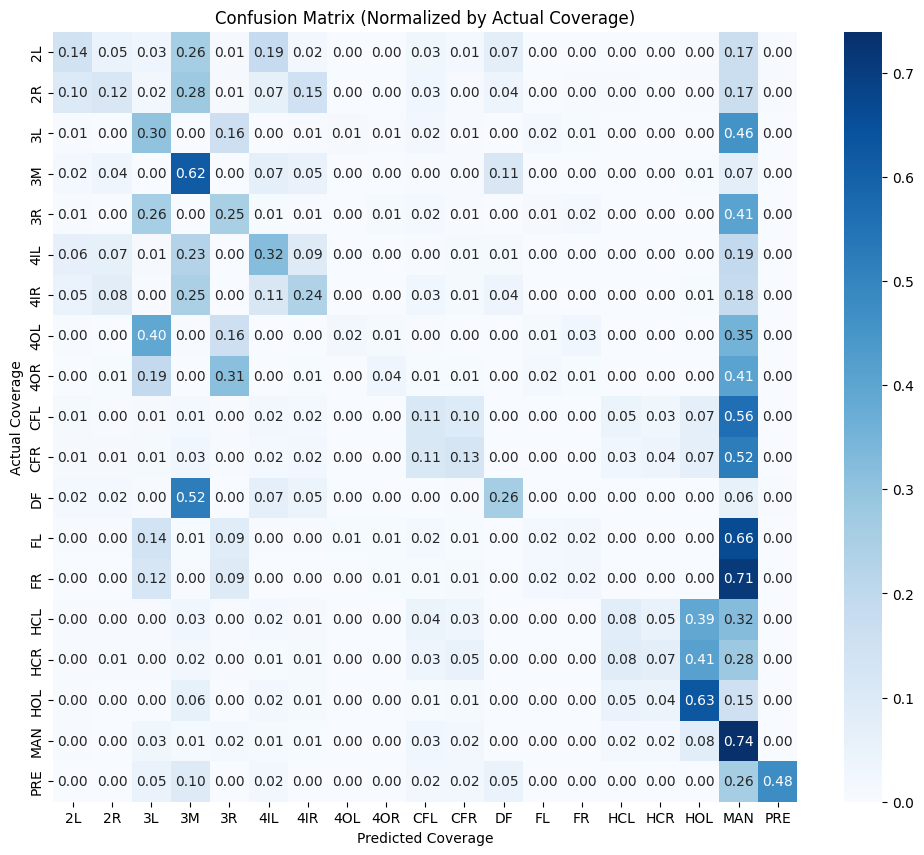

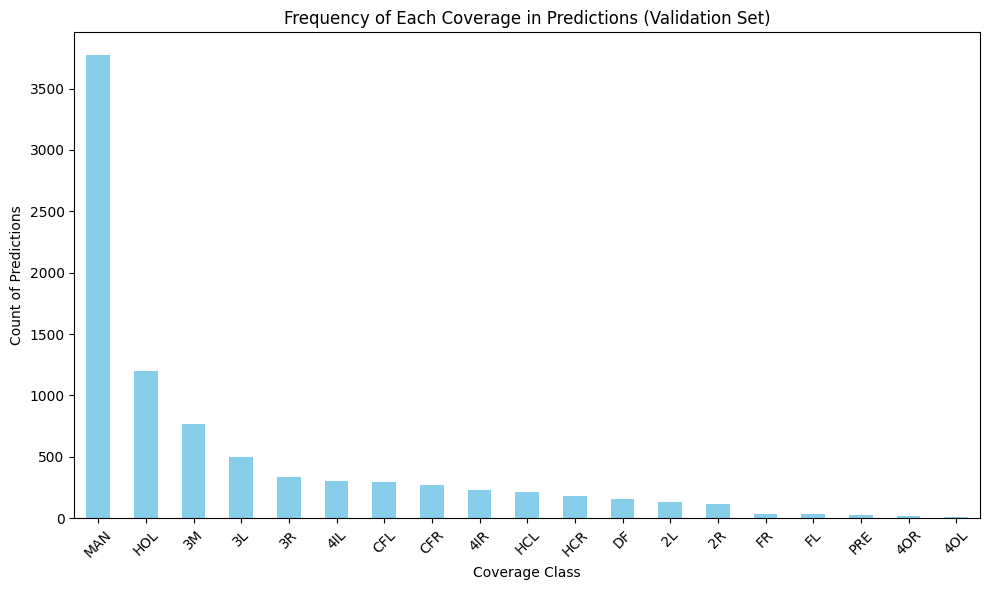

/var/folders/lc/7rv1sjyd6svbqbc44bkn80nh0000gn/T/ipykernel_37372/2524352760.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_per_class_df, x="Accuracy", y="Coverage_Class", palette="Blues_d")


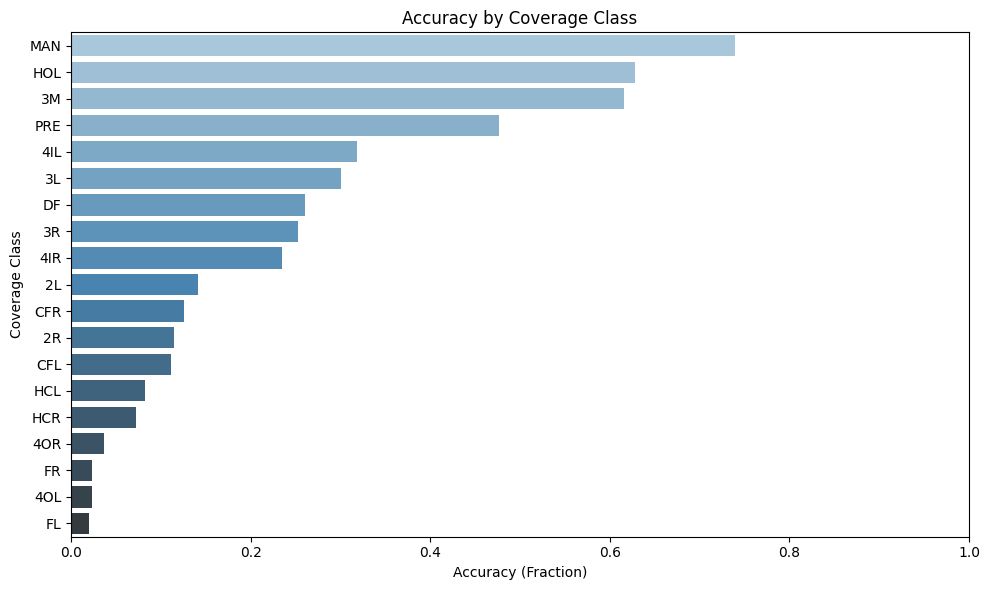

Overall Validation Accuracy: 0.3527

Accuracy per Coverage Class:
  2L: 14.18%
  2R: 11.50%
  3L: 30.08%
  3M: 61.54%
  3R: 25.26%
  4IL: 31.86%
  4IR: 23.53%
  4OL: 2.27%
  4OR: 3.70%
  CFL: 11.09%
  CFR: 12.52%
  DF: 26.05%
  FL: 1.95%
  FR: 2.35%
  HCL: 8.24%
  HCR: 7.28%
  HOL: 62.78%
  MAN: 73.96%
  PRE: 47.62%


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

y_val_pred = model_coverage.predict(X_val)

y_val_array = y_val.to_numpy()

cm = confusion_matrix(y_val_array, y_val_pred)

coverage_classes = le_coverage.classes_

cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    cmap="Blues", 
    xticklabels=coverage_classes, 
    yticklabels=coverage_classes, 
    fmt=".2f"
)
plt.title("Confusion Matrix (Normalized by Actual Coverage)")
plt.xlabel("Predicted Coverage")
plt.ylabel("Actual Coverage")
plt.show()

pred_counts = pd.Series(y_val_pred).value_counts()

pred_counts.index = coverage_classes[pred_counts.index]

plt.figure(figsize=(10, 6))
pred_counts.plot(kind="bar", color="skyblue")
plt.title("Frequency of Each Coverage in Predictions (Validation Set)")
plt.xlabel("Coverage Class")
plt.ylabel("Count of Predictions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

accuracy_per_class = {}
for i, coverage_class in enumerate(coverage_classes):
    idx = (y_val_array == i)
    total = np.sum(idx)
    if total > 0:
        correct = np.sum(y_val_pred[idx] == i)
        accuracy_per_class[coverage_class] = correct / total
    else:
        accuracy_per_class[coverage_class] = 0

accuracy_per_class_df = pd.DataFrame(
    list(accuracy_per_class.items()), 
    columns=["Coverage_Class", "Accuracy"]
).sort_values("Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_per_class_df, x="Accuracy", y="Coverage_Class", palette="Blues_d")
plt.title("Accuracy by Coverage Class")
plt.xlabel("Accuracy (Fraction)")
plt.ylabel("Coverage Class")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

overall_acc = accuracy_score(y_val_array, y_val_pred)
print(f"Overall Validation Accuracy: {overall_acc:.4f}")
print("\nAccuracy per Coverage Class:")
for cov_class, acc in accuracy_per_class.items():
    print(f"  {cov_class}: {acc:.2%}")


Coverage Percentages Across the Dataset:
pff_defensiveCoverageAssignment
MAN    23.536484
HOL     7.945683
CFR     7.179629
CFL     7.164216
HCL     6.973088
HCR     6.956133
3M      4.913838
3L      4.415981
3R      4.354327
DF      3.098123
2L      3.091957
2R      3.088875
4IL     3.039551
4IR     3.010265
FL      2.985604
FR      2.900829
4OL     2.452295
4OR     2.362897
PRE     0.530226
Name: count, dtype: float64


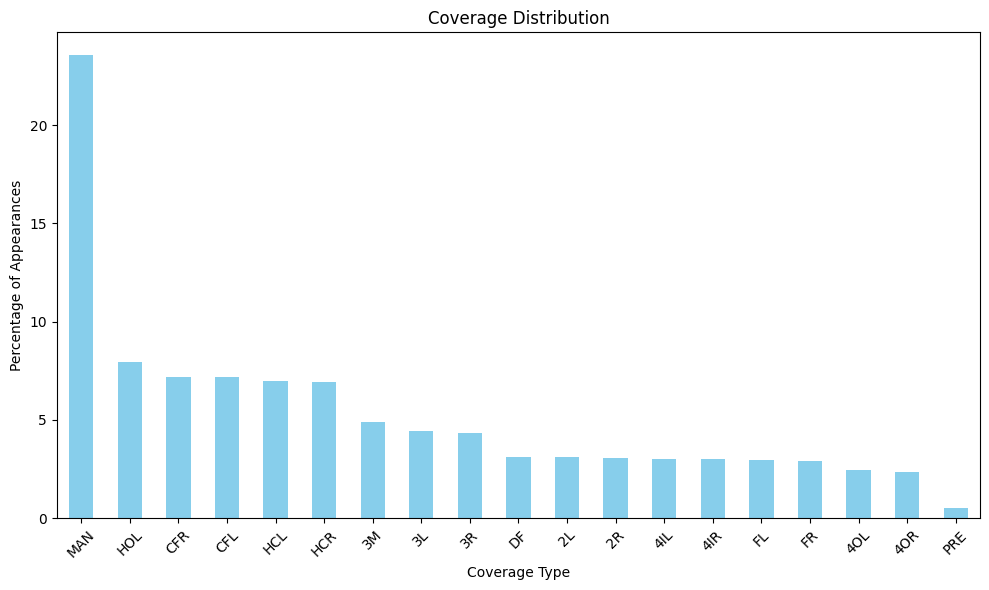

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

coverage_col = 'pff_defensiveCoverageAssignment'

coverage_series = defenders_off_line[coverage_col].dropna()

coverage_counts = coverage_series.value_counts()

coverage_percentages = (coverage_counts / coverage_counts.sum()) * 100

print("Coverage Percentages Across the Dataset:")
print(coverage_percentages)

plt.figure(figsize=(10, 6))
coverage_percentages.plot(kind='bar', color='skyblue')
plt.title("Coverage Distribution")
plt.xlabel("Coverage Type")
plt.ylabel("Percentage of Appearances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.1,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        random_seed=42
    )
}

results = []

for model_name, model in models.items():
    print(f"Training: {model_name}")

    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)

    if hasattr(model, "predict_proba"):
        coverage_probs = model.predict_proba(X_val)
        ll = log_loss(y_val, coverage_probs)
    else:
        ll = None

    acc = accuracy_score(y_val, y_val_pred)

    print(f"  Validation Accuracy: {acc:.4f}")
    if ll is not None:
        print(f"  Validation Log Loss: {ll:.4f}")
    print("-"*40)

    results.append((model_name, acc, ll))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "LogLoss"])
print("\nSummary of Model Performance on Validation Set:")
print(results_df.sort_values("Accuracy", ascending=False))


Training: LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Validation Accuracy: 0.3017
  Validation Log Loss: 2.0532
----------------------------------------
Training: RandomForest
  Validation Accuracy: 0.3517
  Validation Log Loss: 1.8549
----------------------------------------
Training: XGBoost


/Users/wyattbellinger/Library/Python/3.10/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Validation Accuracy: 0.3370
  Validation Log Loss: 1.9076
----------------------------------------
Training: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4596
[LightGBM] [Info] Number of data points in the train set: 34434, number of used features: 19
[LightGBM] [Info] Start training from score -3.513377
[LightGBM] [Info] Start training from score -3.477009
[LightGBM] [Info] Start training from score -3.099500
[LightGBM] [Info] Start training from score -2.997302
[LightGBM] [Info] Start training from score -3.122969
[LightGBM] [Info] Start training from score -3.512403
[LightGBM] [Info] Start training from score -3.549095
[LightGBM] [Info] Start training from score -3.810853
[LightGBM] [Info] Start training from score -3.764691
[LightGBM] [Info] Start training from score -2.639290
[LightGBM] [Info] Start training from score -2.6348